<a href="https://www.kaggle.com/code/bayramakdag/forex-forecasting?scriptVersionId=208879538" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [19]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE as AUTO
import random

In [20]:
# Veri setini yükleme
data_csv = pd.read_csv('/kaggle/input/eur-usd-forex-pair-historical-data-2002-2019/eurusd_hour.csv')
data_csv.set_index(['Date'], inplace=True)
data = data_csv.filter(['BC'])

print("Veri setinin ilk 5 satırı:")
print(data.head())

# Rastgele eksik veriler oluşturma fonksiyonu
def add_random_missing_values(dataframe: pd.DataFrame, missing_rate: float = 0.01, seed: int = 42) -> pd.DataFrame:

    # Veri çerçevesinin kopyasını oluştur
    df_missing = dataframe.copy()

    # Veri çerçevesinin boyutunu ve eklenecek eksik veri sayısını hesapla
    df_size = dataframe.size
    num_missing = int(df_size * missing_rate)

    # Rastgelelik için tohum ayarla
    random.seed(seed)

    # Rastgele hücrelere NaN değeri ekle
    for _ in range(num_missing):
        row_idx = random.randint(0, dataframe.shape[0] - 1)
        col_idx = random.randint(0, dataframe.shape[1] - 1)
        df_missing.iat[row_idx, col_idx] = np.nan

    return df_missing

# Eksik veri oranını rastgele %1 ile %3 arasında belirle
missing_rate = random.uniform(0.01, 0.03)

# Fonksiyonu uygulayarak eksik veri ekle
data_with_missing = add_random_missing_values(data, missing_rate=missing_rate)

# Eksik veri analizini yap
missing_data = data_with_missing.isnull()
missing_count = missing_data.sum()
total_missing = missing_count.sum()

print(f"\nUygulanan eksik veri oranı: {missing_rate:.2%}")
print("\nHer sütundaki eksik veri sayısı:")
print(missing_count)
print(f"\nToplam eksik veri sayısı: {total_missing}")


Veri setinin ilk 5 satırı:
                BC
Date              
2005-05-02  1.2844
2005-05-02  1.2842
2005-05-02  1.2851
2005-05-02  1.2851
2005-05-02  1.2855

Uygulanan eksik veri oranı: 1.89%

Her sütundaki eksik veri sayısı:
BC    1741
dtype: int64

Toplam eksik veri sayısı: 1741


 EUR/USD tarihsel döviz kuru veri setine rastgele eksik veriler ekleyeceğiz ve ardından bu eksik verileri analiz edeceğiz. Bu, veri ön işleme ve eksik veri analizi için önemli bir adımdır.
  Kaggle veri setini yüklüyoruz ve yalnızca "BC" (kapanış fiyatı) sütununu analiz etmek üzere seçiyoruz.
  Daha sonrasında, veri setine belirli bir oran (%1 - %3) arasında rastgele eksik veriler ekler. Eksik veri oranını rastgele %1 ile %3 arasında bir değer olarak belirliyor ve veri setine uyguluyoruz.
  Son olarak, eksik veri eklenen veri setinde eksik verileri analiz ediyoruz:

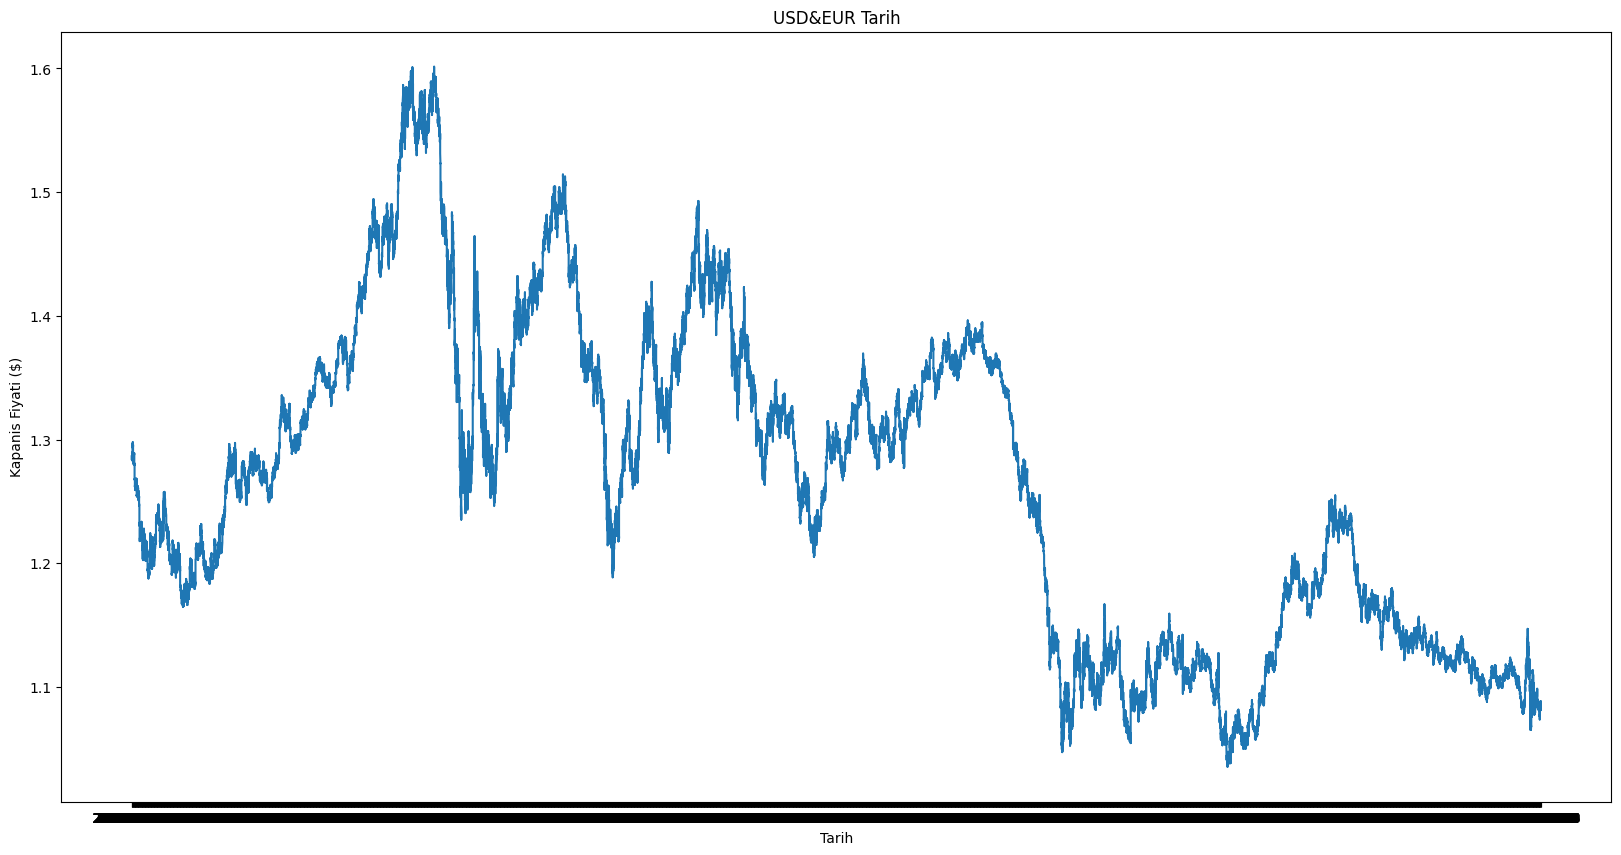

In [21]:
# Görselleştirme
plt.figure(figsize=(20,10))
plt.plot(data['BC'])
plt.title('USD&EUR Tarih')
plt.xlabel('Tarih')
plt.ylabel('Kapanis Fiyati ($)')
plt.show()

LSTM modeli, zaman serisi tahmini yapmak için eğitilecek. Modelin başarısını, eğitim ve doğrulama veri setlerinin görselleştirilmesiyle değerlendireceğiz.

In [22]:
# Normalizasyon
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.95)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

Bu bölümde, veri seti üzerinde normalizasyon işlemi yapılır. Normalizasyon, verilerin belirli bir aralığa (bu durumda 0 ile 1 arasında) dönüştürülmesi işlemidir. Bu işlem, özellikle makine öğrenmesi modellerinde, özellikle sinir ağları gibi algoritmalarda daha hızlı ve verimli sonuçlar elde etmek için yaygın olarak kullanılır. 

İlk adımda ki data dataframe'ndeki değerler (özellikler) bir NumPy dizisine (`dataset`) dönüştürülür. Bu sayede veri üzerinde işlemler daha hızlı bir şekilde yapılabilir.

In [23]:
# Eğitim verisi oluşturma
window = 10
train_data = scaled_data[0:training_data_len, :]
x_train, y_train = [], []

for i in range(window, len(train_data)):
    x_train.append(train_data[i - window:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Bu adımda, eğitim verisi hazırlanır ve modelin öğrenebilmesi için uygun formata dönüştürülür. Bu süreç, zaman serisi verisiyle çalışırken, önceki değerlerin gelecekteki değerleri tahmin etmek için nasıl kullanılacağını belirler. Bu örnekte, LSTM (Long Short-Term Memory modeline uygun bir eğitim veri seti oluşturuluyor.

window parametresi, modelin her bir tahmin için kaç geçmiş gözlem kullanacağını belirler. Bu örnekte, 30 geçmiş gözlem kullanılarak tahmin yapılacak.

In [24]:
# Model oluşturma
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Bu katman, modelin ilk LSTM katmanıdır ve 50 birim içerir.
return_sequences = True parametresi, bu katmandan çıkan her zaman adımında bir dizi değer döndüreceğini belirtir. Bu, bir sonraki LSTM katmanına çoklu zaman adımlarının aktarılmasını sağlar.

Bu, modelin beklediği giriş verisinin şeklidir. Buradaki x_train.shape[1], her bir zaman adımındaki gözlem sayısını ifade eder ve 1 ise her adım için tek bir özelliği belirtir.

In [25]:
# Modeli eğitme
model.fit(x_train, y_train, batch_size=30, epochs=10)

Epoch 1/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.0032
Epoch 2/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 4.5241e-05
Epoch 3/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 3.3490e-05
Epoch 4/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 2.3363e-05
Epoch 5/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 1.6610e-05
Epoch 6/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 1.4015e-05
Epoch 7/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 1.4071e-05
Epoch 8/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 1.3133e-05
Epoch 9/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 1.3698e-05
Epoch 10/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 1.2647e-05


Bu adımda, LSTM modelini eğitim verisi ile eğitmek için model.fit() fonksiyonu kullanılır. Model, eğitim verisi üzerinde 30 örnekten oluşan küçük gruplarla (batch_size) ve 10 epoch boyunca eğitilecektir. 

model.fit() fonksiyonu, modelin eğitim verisi (x_train) ve hedef verisi (y_train) ile eğitilmesini sağlar. Bu fonksiyon, modelin batch_size ve epochs gibi eğitim parametrelerini de alır.

In [26]:
# Test verisi
test_data = scaled_data[training_data_len - window:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i - window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Bu adımda, modelin doğruluğunu test etmek için test verisi hazırlanır. Test verisi, eğitim verisinden farklı olarak, modelin daha önce görmediği verilerle tahminler yapmasını sağlar. Bu aşamada, test verisi normalleştirilmiş (scaled) hale getirilmiş ve uygun formata sokulmuştur.

Eğitim verisinden sonra gelen veriler test verisi olarak kullanılır. training_data_len - window ifadesi, test verisinin başlangıcını belirler. Burada window parametresi, geçmiş verileri kullanarak yapılan tahminlerdeki zaman adımı uzunluğudur.

In [27]:
# Tahminler
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Bu adımda, eğitilmiş LSTM modeli, test verisi üzerinde tahminlerde bulunur. Model, test verisindeki her örnek için gelecekteki değeri tahmin eder ve bu tahminler, normalize edilmiş (scaled) formatta olduğu için orijinal ölçekteki değerlere geri dönüştürülür.

Test verisi olan x_test üzerinde modelin tahmin yapması sağlanır. Model, her bir giriş örneği için tek bir tahmin değeri üretir. 

/tmp/ipykernel_30/1195883338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Tahminler'] = pred


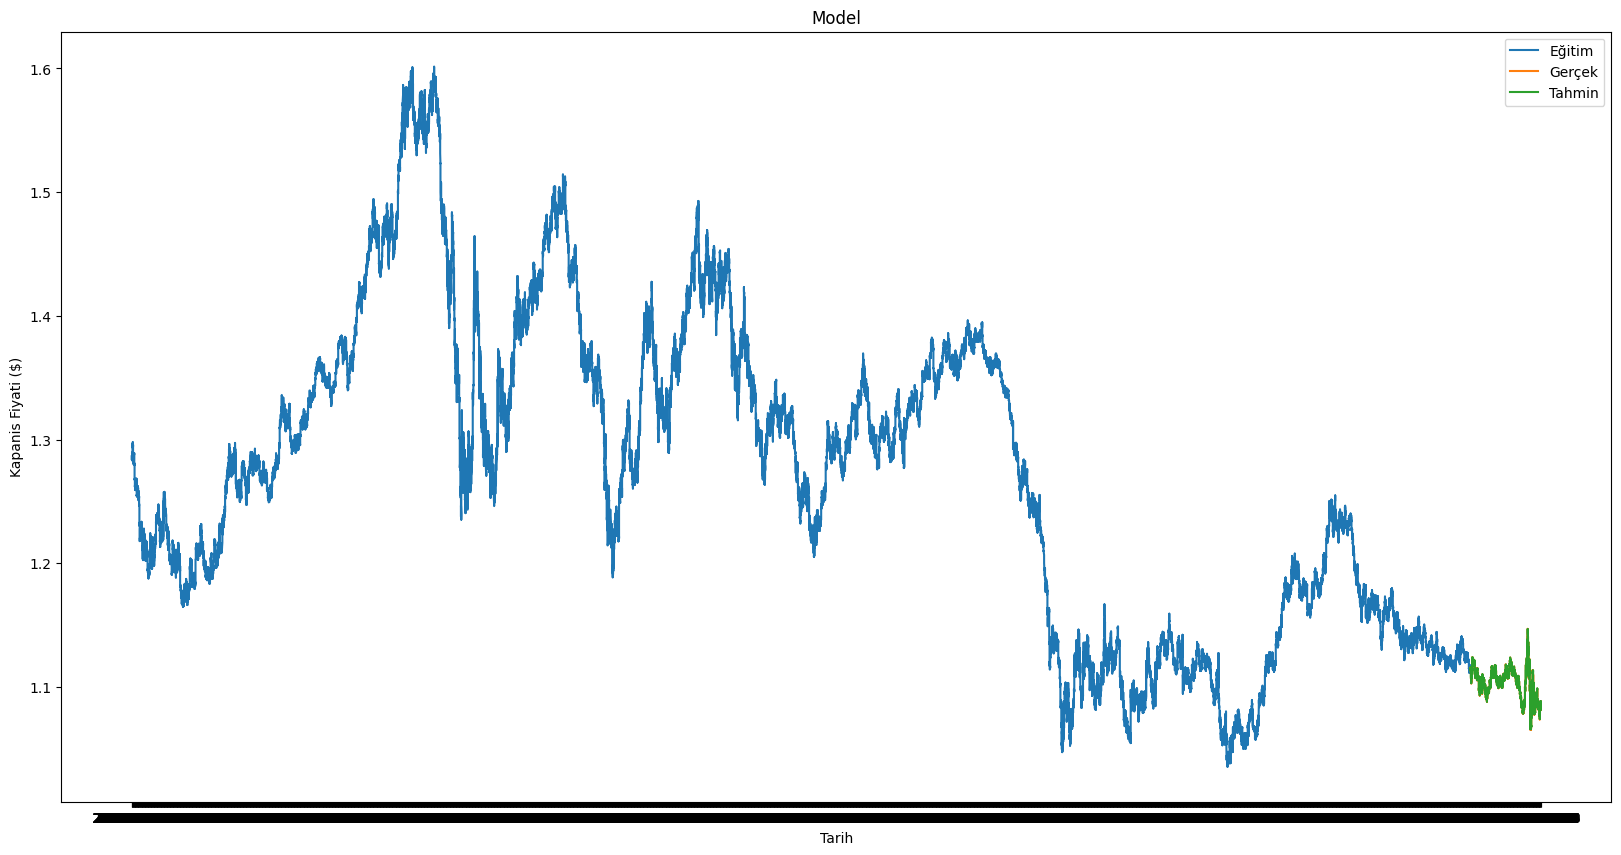

In [28]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Tahminler'] = pred

plt.figure(figsize=(20,10))
plt.plot(train['BC'])
plt.plot(valid[['BC', 'Tahminler']])
plt.title('Model')
plt.xlabel('Tarih')
plt.ylabel('Kapanis Fiyati ($)')
plt.legend(['Eğitim', 'Gerçek', 'Tahmin'])
plt.show()

Bu adımda, modelin tahmin sonuçları, gerçek verilerle karşılaştırılarak görselleştirilir. Eğitim verisi (train), gerçek test verisi (valid) ve modelin tahmin ettiği değerler (Tahminler) bir grafik üzerinde gösterilir.
Eğitim veri kümesinin ilk training_data_len kadar verisi seçilir.

Eğitim verisinden sonra gelen veri kısmı test verisi olarak kullanılır.